In [15]:
# Imports
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision import models
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import random_split
import tqdm
import wandb
import time

# Set up GPU
gpu_avail = torch.cuda.is_available()
print(f"Is CUDA available?  {torch.cuda.is_available()}")
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Is CUDA available?  True
Device cuda


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Load in data
dataset = datasets.ImageFolder('Data/Colorectal Cancer', transform=transforms.ToTensor())

# Split the data
train_set, test_set = random_split(dataset, [0.7, 0.3])

# Data loaders
train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=32)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=32)

print("Categories: ", dataset.classes)
print("Number of Samples: ", len(dataset))
print("Samples in train set: ", len(train_set))
print("Samples in test set", len(test_set))

# Show some images
# def display(img):
#     plt.imshow(img, interpolation='nearest')

dataiter = iter(train_loader)
images, labels = next(dataiter) # Labels range from {0 = gland, 1 = nongland, 2 = tumor}
# display(images[0].permute(1,2,0))

Categories:  ['MUS', 'NORM', 'STR']
Number of Samples:  6000
Samples in train set:  4200
Samples in test set 1800


In [3]:
# Helper Functions for the model training loop
def accuracy(predictions, labels):
    _, predictions = torch.max(predictions, dim=1)
    return torch.tensor(torch.sum(predictions==labels).item() / len(predictions))

# performs forward propagation and returns loss
def step(model, batch, loss, testing=False):
    images, labels = batch
    images, labels = images.to(device), labels.to(device)
    predictions = model(images)

    if(testing):
        l = loss(predictions, labels)
        acc = accuracy(predictions, labels)
        return {'test loss':l.detach(), 'accuracy': acc}
    return loss(predictions, labels)

# Return mean loss and accuracy per epoch
def epoch_end_stats(predictions):
    batch_losses = [p['test loss'] for p in predictions]
    epoch_loss = torch.stack(batch_losses).mean() # Avg losses
    batch_accs = [p['accuracy'] for p in predictions]
    epoch_acc = torch.stack(batch_accs).mean() # Avg accuracies
    logs = {'test loss': epoch_loss.item(), 'accuracy': epoch_acc.item()}
    # run.log(logs)
    return logs # Return means

# Evaluate loop
def evaluate(model, loss, test_loader):
    model.eval()
    predictions = [step(model, batch, loss, testing=True) for batch in test_loader]
    return epoch_end_stats(predictions)


In [7]:
# Setup WandB Config
# run = wandb.init(
#     project="432-Task-01-v02",
#     id="01",

#     config={
#         "learning_rate": 0.01,
#         "architecture": "ResNet50 CNN",
#         "dataset": "Colectoral Cancer",
#         "epochs": 10,
#     }
# )

In [23]:
# Import ResNet
rs50 = models.resnet50()
rs50.fc = torch.nn.Sequential(
    torch.nn.Linear(
        in_features=2048,
        out_features=3
    ),
    torch.nn.Sigmoid()
)
rs50.to(device);

# Define loss function and optimizer
loss = nn.CrossEntropyLoss()

optimizer = optim.Adam(rs50.parameters(), lr=0.01)
optimizerSGD = optim.SGD(rs50.parameters(), lr=0.01, momentum=0.9)

# setup scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizerSGD, mode='min', factor=0.2, 
                                                 patience=3, threshold=0.001, threshold_mode='rel', cooldown=0,
                                                 min_lr=1e-6, eps=1e-08)

# Create training loop
def train(model, loss, optimizer, train_loader, test_loader, losses, epoch):
    model.train()
    results = []
    with tqdm.tqdm(total=len(train_loader), desc=f'Epoch {epoch}') as pbar:
        for batch in train_loader:
            # Perform forward propagation
            l = step(model, batch, loss)

            # Record loss, and perform back propagation
            losses.append(l)
            optimizer.zero_grad() # reset gradients
            l.backward()
            optimizer.step()
            pbar.update()

        # After each batch we evaluate the model:
        result = evaluate(model, loss, test_loader)
        result['train loss'] = torch.stack(losses).mean().item()
        # run.log({'train loss': result['train loss']})
        pbar.set_postfix_str(f'train_loss={result['train loss']} test_loss={result['test loss']}, accuracy={result['accuracy']*100:.2f}%')
        # print(f'train_loss={result['train loss']} test_loss={result['test loss']}, accuracy={result['accuracy']*100:.2f}%')
        results.append(result)
    return results

# set memory allocation and empty cache
PYTORCH_CUDA_ALLOC_CONF='cudaMallocAsync'
# torch.cuda.empty_cache()

In [24]:
%%time
# Train the model
epochs = 20
losses = []
results = []
for i in range(epochs):
    results.append(train(rs50,loss=loss,optimizer=optimizerSGD, train_loader=train_loader, test_loader=test_loader, losses=losses, epoch=i+1))
    scheduler.step(losses[-1])
print("\nTraining Complete!")
# wandb.finish()

Epoch 20: 100%|██████████| 132/132 [00:36<00:00,  3.65it/s, train_loss=0.6658725142478943 test_loss=0.665235161781311, accuracy=88.16%]


Training Complete!
CPU times: total: 1h 11min 52s
Wall time: 12min 6s


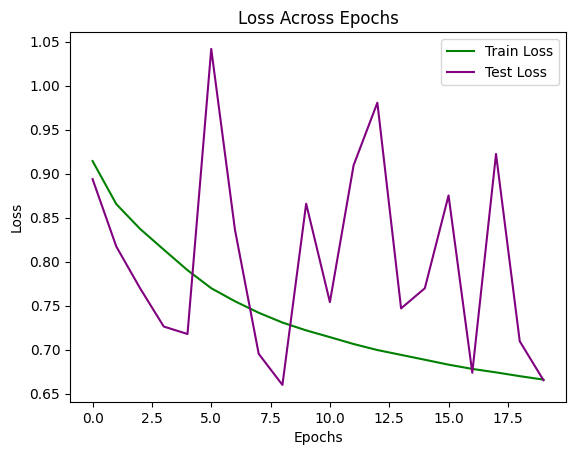

In [27]:
# Plot Results
test_losses = [entry['test loss'] for entry in results]
train_losses = [entry['train loss'] for entry in results]
acc = [entry['accuracy'] for entry in results]

plt.plot(train_losses, color="green", label="Train Loss")
plt.plot(test_losses, color="purple", label="Test Loss")
plt.title("Loss Across Epochs")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

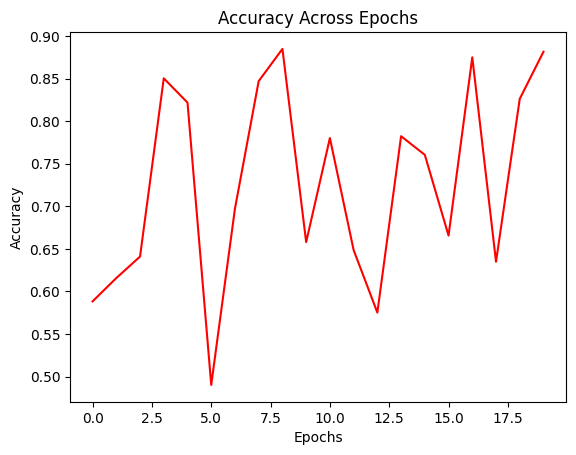

In [28]:
plt.plot(acc, color="red")
plt.title("Accuracy Across Epochs")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.show()

In [ ]:
# Save model for later?
torch.save(rs50.state_dict(), "colocteral-cancer-model-01.tar")